# Lecture 6: Preprocessing and `sklearn` pipelines

MTU Spring 2024

Instructor: Abel Reyes

### Announcements
- Homework 2 is out. Please start early (make sure to submit it on time). 
- Homework 1 grades will be posted tonight
- Quiz 1 grades available - **good job!**
- No Quiz this week!. 

### Learning outcomes

From this lecture, you will be able to 

- explain motivation for preprocessing in supervised machine learning;
- identify when to implement feature transformations such as imputation, scaling, and one-hot encoding in a machine learning model development pipeline; 
- use `sklearn` transformers for applying feature transformations on your dataset;
- discuss golden rule in the context of feature transformations;
- use `sklearn.pipeline.Pipeline` and `sklearn.pipeline.make_pipeline` to build a preliminary machine learning pipeline. 

### Imports

In [41]:
import sys
import time

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append("code/.")

import mglearn
from IPython.display import display
from plotting_functions import *

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *

pd.set_option("display.max_colwidth", 200)

## Motivation 
- Are we ready to do machine learning on real-world datasets?
    - Very often real-world datasets need preprocessing before we use them to build ML models. 

### Common preprocessing techniques

Some commonly performed feature transformation include:  
- Imputation: Tackling missing values
- Scaling: Scaling of numeric features
- One-hot encoding: Tackling categorical variables      
    

We can have one lecture on each of them! In this lecture our goal is to getting familiar with them so that we can use them to build ML pipelines. 

## First, some examples

In [119]:
from io import StringIO
import sys



In [122]:
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# Replace consecutive commas with NaN
csv_data = csv_data.replace(',,', ',NaN,')

df = pd.read_csv(StringIO(csv_data))
print(df)


      A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN


In [123]:
# remove rows that contain missing values
df.dropna(axis=0)


,A,B,C,D
0,1.0,2.0,3.0,4.0


In [124]:
# remove columns that contain missing values
 
df.dropna(axis=1)


,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [126]:
# only drop rows where all columns are NaN
df.dropna(how='all')


,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


## Imputing missing values

In [127]:
# Impute missing values via the column mean

from sklearn.impute import SimpleImputer
import numpy as np

imr=SimpleImputer(missing_values=np.nan, strategy='mean')
imr=imr.fit(df.values)
imputed_data=imr.transform(df.values)
imputed_data


array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

## Handling categorical data

In [142]:
df=pd.DataFrame([['green', 'M', 10.1, 'class2'],
                ['red', 'L', 13.5, 'class1'],
                ['blue', 'XL', 15.3, 'class2']])

df.columns=['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [148]:
#Mapping ordinal features
size_mapping={'XL': 3,
             'L': 2,
             'M': 1}


df['size']=df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [131]:
# Encoding class labels – label encoding (I)

## Create a mapping dict
## to convert class labels from string to integers
class_mapping={label:idx for idx, label in \
              enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [132]:
## mapping
df['classlabel']=df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [133]:
# Encoding class labels – label encoding (II)
from sklearn.preprocessing import LabelEncoder

## Label encoding with sklearn's LabelEncoder

class_label=LabelEncoder()
y=class_label.fit_transform(df['classlabel'].values)
print("Encoded class label: ",y)
print("----")
print(df)

Encoded class label:  [1 0 1]
----
   color  size  price  classlabel
0  green     1   10.1           1
1    red     2   13.5           0
2   blue     3   15.3           1


In [144]:
# Encoding on nominal features
X=df[['color', 'size', 'price']].values
color_le=LabelEncoder()
X[:,1]=color_le.fit_transform(X[:,1])
X

array([['green', 1, 10.1],
       ['red', 0, 13.5],
       ['blue', 2, 15.3]], dtype=object)

In [146]:
## Performing one-hot encoding on nominal features

from sklearn.preprocessing import OneHotEncoder

X=df[['color', 'size', 'price']].values
color_ohe=OneHotEncoder()
color_ohe.fit_transform(X[:,0].reshape(-1,1)).toarray()



array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [149]:
## We can select which columns to encode in a multi-feature array

from sklearn.compose import ColumnTransformer

X=df[['color', 'size', 'price']].values
c_transf=ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                            ('nothing', 'passthrough', [1,2])
                           ])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

## Feature Scaling

### Bringing features onto the same scale

- Various different features can differ by orders of magnitude, where large values can domain smaller values.
- The majority of ML methods performs better if features are on the same scale. 
- Common strategies to apply feature scaling:
    1. Normalization: rescaling feature to a range of [0, 1]	
    2. Standardization: centering the feature columns at mean with standard deviation 1 so that it forms a standard normal distribution.


In [150]:
## Normalization example

from sklearn.preprocessing import MinMaxScaler

X=np.array([[1,2],[3,4],[12,8],[10,9],[15,2],[5,1]])

mms=MinMaxScaler()
X_norm=mms.fit_transform(X)

print("Before scaling:\n", X)
print("\n")
print("After scaling:\n", X_norm)

Before scaling:
 [[ 1  2]
 [ 3  4]
 [12  8]
 [10  9]
 [15  2]
 [ 5  1]]


After scaling:
 [[0.         0.125     ]
 [0.14285714 0.375     ]
 [0.78571429 0.875     ]
 [0.64285714 1.        ]
 [1.         0.125     ]
 [0.28571429 0.        ]]


In [154]:
## Standardization example
np.std(X)

4.4907311951024935

In [153]:
from sklearn.preprocessing import StandardScaler
stdsc=StandardScaler()
X_std=stdsc.fit_transform(X)
print("Before standardization:\n", X)
print("\n")
print("After standardization:\n", X_std)

Before standardization:
 [[ 1  2]
 [ 3  4]
 [12  8]
 [10  9]
 [15  2]
 [ 5  1]]


After standardization:
 [[-1.32744662 -0.75482941]
 [-0.92921264 -0.10783277]
 [ 0.86284031  1.18616051]
 [ 0.46460632  1.50965882]
 [ 1.46019129 -0.75482941]
 [-0.53097865 -1.07832773]]


In [156]:
np.std(X_std)

1.0

## Feature Selection
- Select a subset of the original features. 
- Scikit-learn provide a variate of different [feature selection methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection).



In [157]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X, y = load_iris(return_X_y=True)
print(X.shape)
print(X[0,:])

(150, 4)
[5.1 3.5 1.4 0.2]


In [158]:
X_new=SelectKBest(chi2, k=2).fit_transform(X,y)
print(X_new.shape)
print(X_new[0,:])

(150, 2)
[1.4 0.2]


## Correlation map

In [170]:
data= load_iris(return_X_y=False)
df = pd.DataFrame(data=data.data, columns=data.feature_names)


In [171]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [ ]:
!pip install seaborn

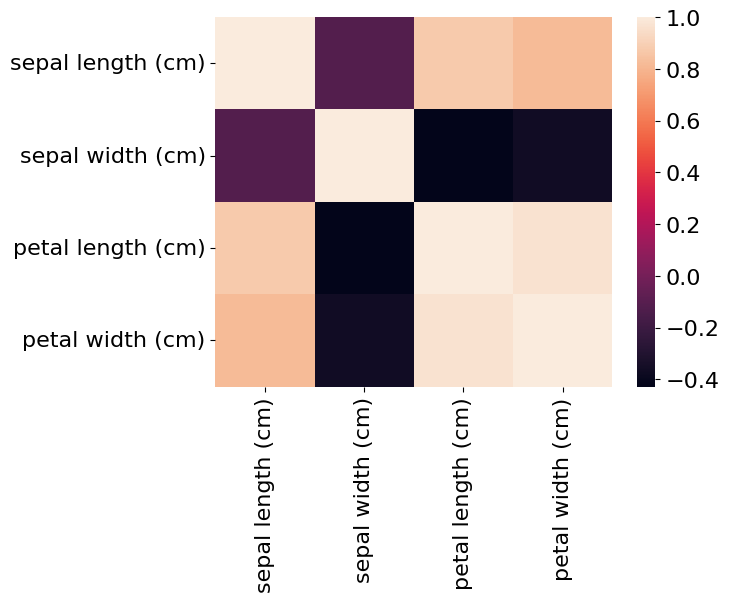

In [175]:
import seaborn as sns

sns.heatmap(df.corr());


In order to run the code below, you need to download the dataset from [Kaggle](https://www.kaggle.com/geomack/spotifyclassification/download).

In the next part of this lecture, we'll build an ML pipeline using [California housing prices regression dataset](https://www.kaggle.com/harrywang/housing). In the process, we will talk about different feature transformations and how can we apply them so that we do not violate the golden rule. 

## Imputation and scaling

### Dataset, splitting, and baseline

We'll be working on [California housing prices regression dataset](https://www.kaggle.com/harrywang/housing) to demonstrate these feature transformation techniques. The task is to predict median house values in Californian districts, given a number of features from these districts. If you are running the notebook on your own, you'll have to download the data and put it in the data directory. 

In [42]:
housing_df = pd.read_csv("data/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)

train_df.head(400)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
7089,-118.00,33.94,37.0,903.0,158.0,444.0,158.0,3.7500,174400.0,<1H OCEAN
4893,-118.25,34.02,32.0,1311.0,410.0,1792.0,396.0,2.3304,119900.0,<1H OCEAN
13448,-117.41,34.10,5.0,4937.0,1139.0,2204.0,812.0,2.5272,92000.0,INLAND
5751,-118.27,34.17,52.0,2010.0,NaN,908.0,326.0,6.9135,374000.0,<1H OCEAN


Some column values are mean/median but some are not. 

Let's add some new features to the dataset which could help predicting the target: `median_house_value`. 

In [43]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

train_df = train_df.assign(
    bedrooms_per_household=train_df["total_bedrooms"] / train_df["households"]
)
test_df = test_df.assign(
    bedrooms_per_household=test_df["total_bedrooms"] / test_df["households"]
)

train_df = train_df.assign(
    population_per_household=train_df["population"] / train_df["households"]
)
test_df = test_df.assign(
    population_per_household=test_df["population"] / test_df["households"]
)

In [44]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN,3.817558,1.004801,4.323045


In [45]:
train_df = train_df.drop(columns = ['population', 'total_rooms', 'total_bedrooms'])
test_df =  test_df.drop(columns = ['population', 'total_rooms', 'total_bedrooms'])

### When is it OK to do things before splitting? 

- Here it would have been OK to add new features before splitting because we are not using any global information in the data but only looking at one row at a time. 
- But just to be safe and to avoid accidentally breaking the golden rule, it's better to do it after splitting. 

- Question: Should we remove `total_rooms`, `total_bedrooms`, and `population` columns? 
    - Probably. But I am keeping them in this lecture. You could experiment with removing them and examine whether results change. 

## EDA

In [46]:
train_df.head()

,longitude,latitude,housing_median_age,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,602.0,3.1250,113600.0,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,20.0,3.4861,137500.0,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,708.0,2.6604,170100.0,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,285.0,5.2139,129300.0,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,1458.0,1.8580,205000.0,NEAR OCEAN,3.817558,1.004801,4.323045


The feature scales are quite different. 

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18576 entries, 6051 to 19966
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 18576 non-null  float64
 1   latitude                  18576 non-null  float64
 2   housing_median_age        18576 non-null  float64
 3   households                18576 non-null  float64
 4   median_income             18576 non-null  float64
 5   median_house_value        18576 non-null  float64
 6   ocean_proximity           18576 non-null  object 
 7   rooms_per_household       18576 non-null  float64
 8   bedrooms_per_household    18391 non-null  float64
 9   population_per_household  18576 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We have one categorical feature and all other features are numeric features. 

In [48]:
train_df.describe()

,longitude,latitude,housing_median_age,households,median_income,median_house_value,rooms_per_household,bedrooms_per_household,population_per_household
count,18576.000000,18576.000000,18576.000000,18576.000000,18576.000000,18576.000000,18576.000000,18391.000000,18576.000000
mean,-119.565888,35.627966,28.622255,500.061100,3.862552,206292.067991,5.426067,1.097516,3.052349
std,1.999622,2.134658,12.588307,383.044313,1.892491,115083.856175,2.512319,0.486266,10.020873
min,-124.350000,32.540000,1.000000,1.000000,0.499900,14999.000000,0.846154,0.333333,0.692308
25%,-121.790000,33.930000,18.000000,280.000000,2.560225,119400.000000,4.439360,1.005888,2.430323
50%,-118.490000,34.250000,29.000000,410.000000,3.527500,179300.000000,5.226415,1.048860,2.818868
75%,-118.010000,37.710000,37.000000,606.000000,4.736900,263600.000000,6.051620,1.099723,3.283921
max,-114.310000,41.950000,52.000000,6082.000000,15.000100,500001.000000,141.909091,34.066667,1243.333333


- Seems like total_bedrooms column has some missing values. 
- This must have affected our new feature `bedrooms_per_household` as well. 

In [49]:
housing_df["total_bedrooms"].isnull().sum()

207

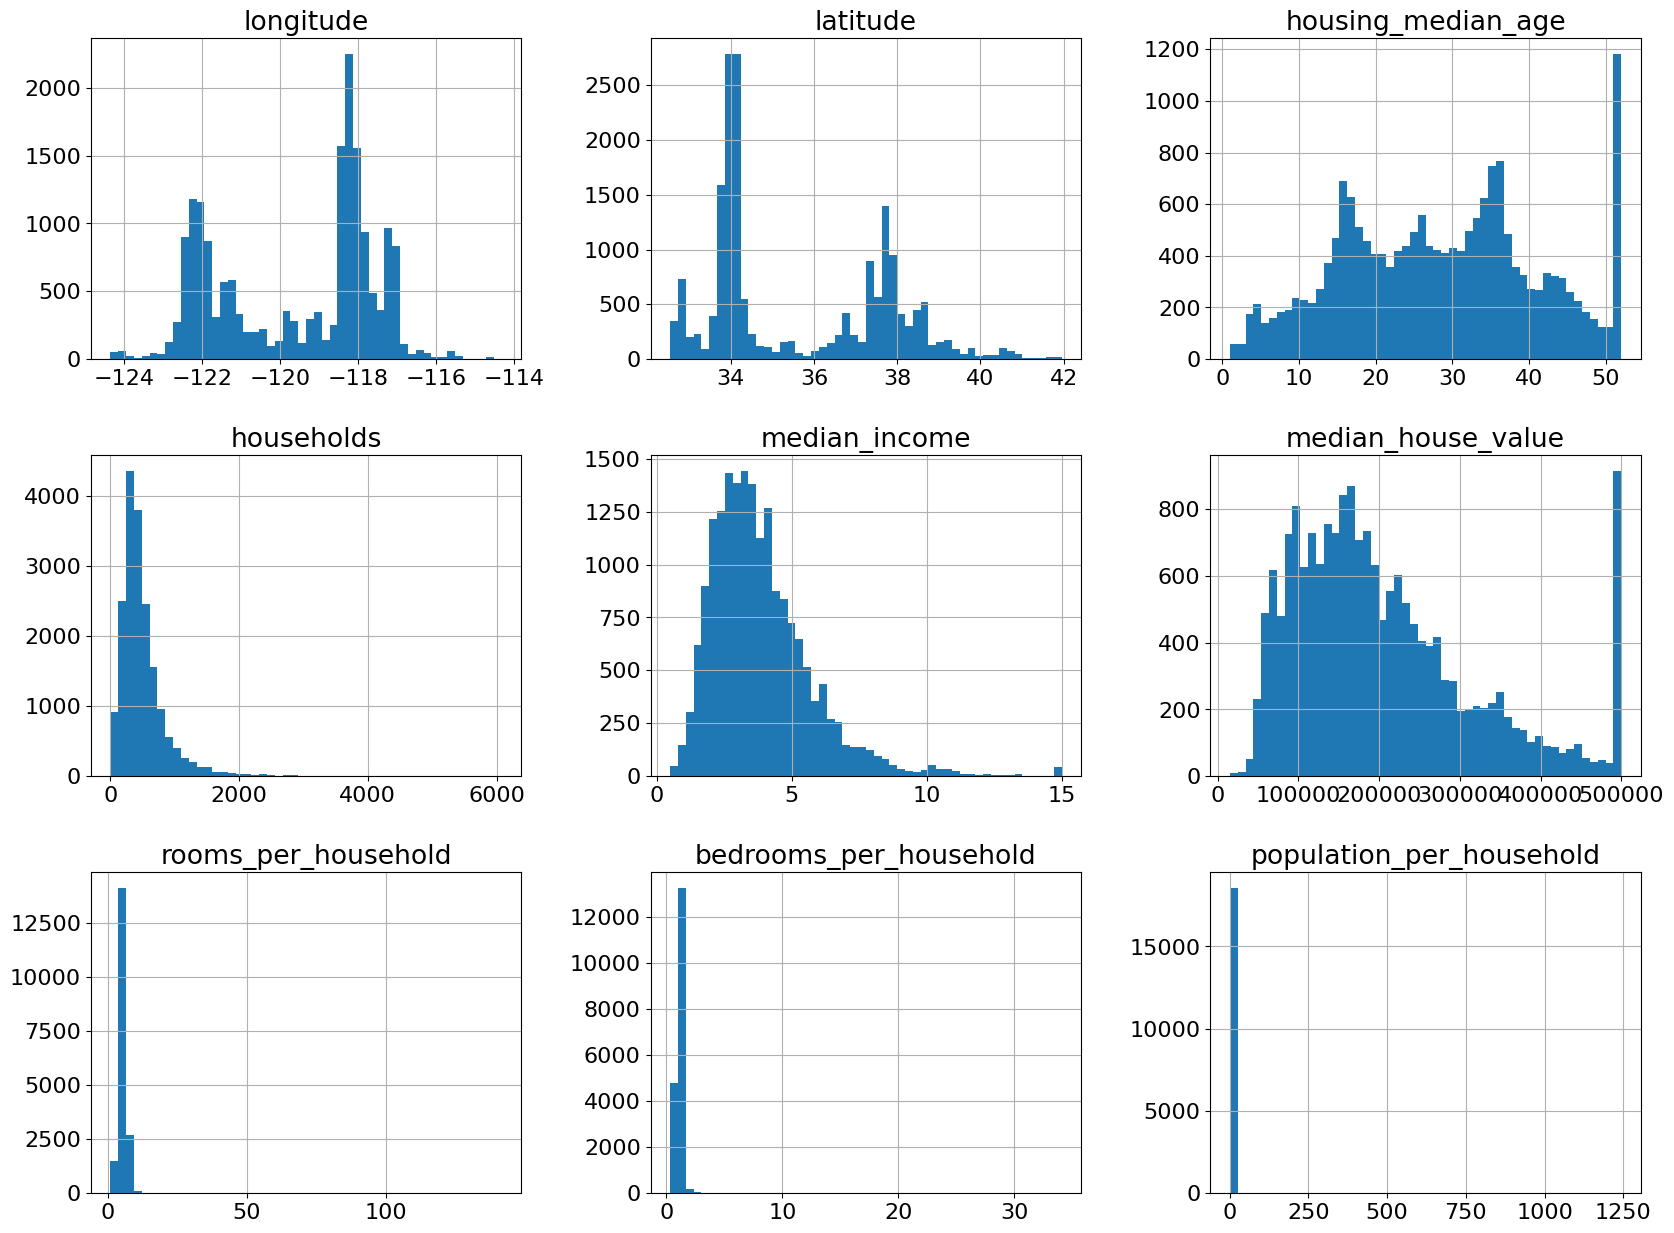

In [50]:
## (optional)
train_df.hist(bins=50, figsize=(20, 15));


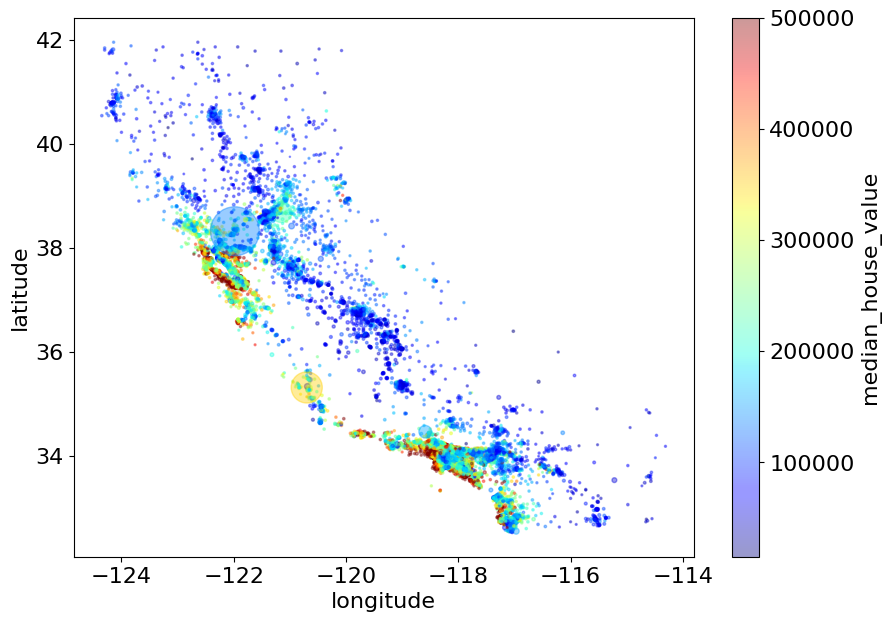

In [51]:
## (optional)
train_df.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=train_df["population_per_household"],
    figsize=(10, 7),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    sharex=False,
);

### What all transformations we need to apply on the dataset? 

Here is what we see from the EDA. 

- Some missing values in `total_bedrooms` column
- Scales are quite different across columns. 
- Categorical variable `ocean_proximity`

Read about [preprocessing techniques implemented in `scikit-learn`](https://scikit-learn.org/stable/modules/preprocessing.html).  

In [52]:
# We are droping the categorical variable ocean_proximity for now. We'll come back to it in a bit.
X_train = train_df.drop(columns=["median_house_value", "ocean_proximity"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value", "ocean_proximity"])
y_test = test_df["median_house_value"]

In [53]:
results_dict = {}  # dictionary to store our results for different models

In [54]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [55]:
dummy = DummyRegressor(strategy="median")
results_dict["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True
)

In [56]:
pd.DataFrame(results_dict)

,dummy
fit_time,0.002 (+/- 0.001)
score_time,0.001 (+/- 0.001)
test_score,-0.055 (+/- 0.012)
train_score,-0.055 (+/- 0.001)


### Imputation 

In [57]:
X_train

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,602.0,3.1250,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,20.0,3.4861,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,708.0,2.6604,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,285.0,5.2139,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,1458.0,1.8580,3.817558,1.004801,4.323045
...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,130.0,3.6389,5.584615,NaN,3.769231
15377,-117.24,33.37,14.0,779.0,4.5391,6.016688,1.017972,3.127086
17730,-121.76,37.33,5.0,697.0,5.6306,5.958393,1.031564,3.493544
15725,-122.44,37.78,44.0,326.0,3.8750,4.739264,1.024540,1.720859


In [58]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

ValueError: Input X contains NaN.
KNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### What's the problem? 

```
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
```

- The classifier is not able to deal with missing values (NaNs).
- What are possible ways to deal with the problem? 
    - Delete the rows? 
    - Replace them with some reasonable values?    

- `SimpleImputer` is a transformer in `sklearn` to deal with this problem. For example, 
    - You can impute missing values in categorical columns with the most frequent value.
    - You can impute the missing values in numeric columns with the mean or median of the column.    

In [59]:
X_train.sort_values("bedrooms_per_household")


,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
20248,-119.23,34.25,28.0,9.0,8.0000,2.888889,0.333333,3.222222
12649,-121.47,38.51,52.0,9.0,3.6250,2.222222,0.444444,8.222222
3125,-117.76,35.22,4.0,6.0,1.6250,3.000000,0.500000,1.333333
12138,-117.22,33.87,16.0,14.0,2.6250,4.000000,0.500000,2.785714
8219,-118.21,33.79,33.0,36.0,4.5938,0.888889,0.500000,2.666667
...,...,...,...,...,...,...,...,...
4591,-118.28,34.06,42.0,1179.0,1.2254,2.096692,NaN,3.218830
19485,-120.98,37.66,10.0,255.0,0.9336,3.662745,NaN,1.572549
6962,-118.05,33.99,38.0,357.0,3.7328,4.535014,NaN,2.481793
14970,-117.01,32.74,31.0,677.0,2.6973,5.129985,NaN,3.098966


In [60]:
X_train.shape, X_test.shape

((18576, 8), (2064, 8))

In [61]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

0.5609808539232339

- Let's check whether the NaN values have been replaced or not
- Note that `imputer.transform` returns an `numpy` array and not a dataframe

In [73]:
np.count_nonzero(np.isnan(X_train_imp))

0

### Check how KNN Regressor would work in this

In [71]:
knn = KNeighborsRegressor()
knn.fit(X_train_imp, y_train)
knn.score(X_train_imp, y_train)

0.5609808539232339

In [74]:
knn.score(X_test_imp, y_test)

0.3195306770443461

### Scaling 

- This problem affects a large number of ML methods.
- A number of approaches to this problem. We are going to look into two most popular ones.  

| Approach | What it does | How to update $X$ (but see below!) | sklearn implementation | 
|---------|------------|-----------------------|----------------|
| standardization | sets sample mean to $0$, s.d. to $1$   | `X -= np.mean(X,axis=0)`<br>`X /=  np.std(X,axis=0)` | [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) |

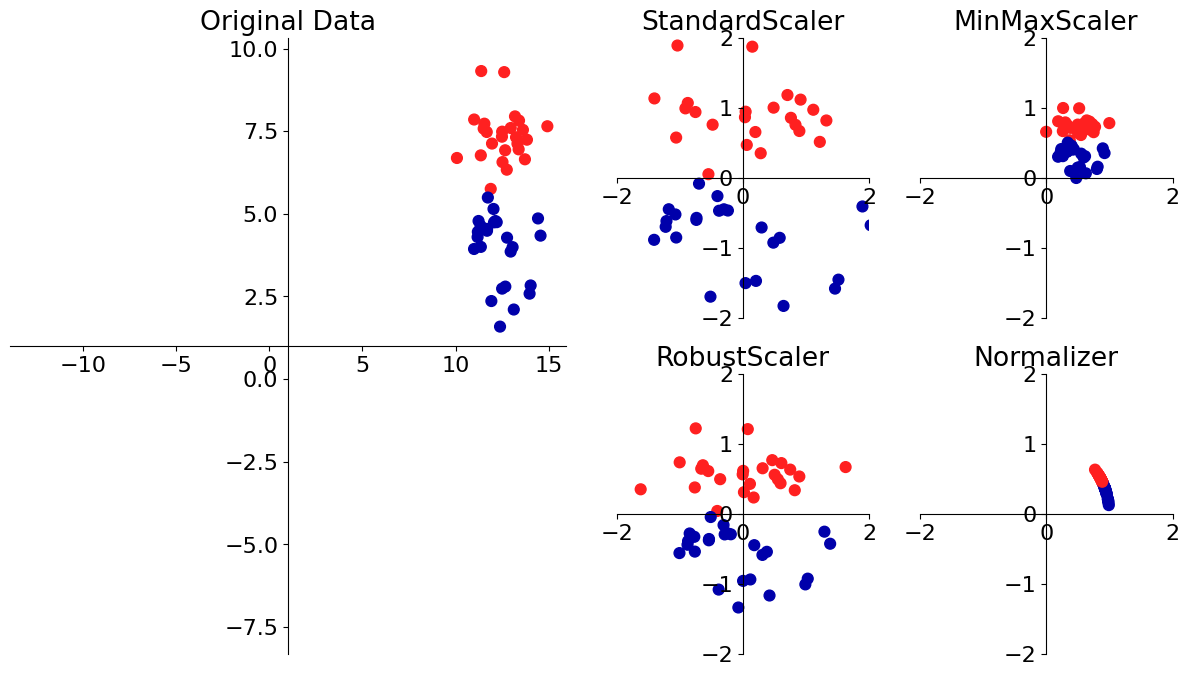

In [62]:
mglearn.plots.plot_scaling()

More infor about the different scaling methods: [here](https://medium.com/@onersarpnalcin/standardscaler-vs-minmaxscaler-vs-robustscaler-which-one-to-use-for-your-next-ml-project-ae5b44f571b9)

In [75]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
0,0.908140,-0.743917,-0.526078,0.266135,-0.389736,-0.210591,-0.083813,0.126398
1,-0.002057,1.083123,-0.923283,-1.253312,-0.198924,4.726412,11.166631,-0.050132
2,1.218207,-1.352930,1.380504,0.542873,-0.635239,-0.273606,-0.025391,-0.099240
3,1.128188,-0.753286,-0.843842,-0.561467,0.714077,0.122307,-0.280310,0.010183
4,1.168196,-1.287344,-0.843842,2.500924,-1.059242,-0.640266,-0.190617,0.126808
...,...,...,...,...,...,...,...,...
18571,0.733102,-0.804818,0.586095,-0.966131,-0.118182,0.063110,-0.099558,0.071541
18572,1.163195,-1.057793,-1.161606,0.728235,0.357500,0.235096,-0.163397,0.007458
18573,-1.097293,0.797355,-1.876574,0.514155,0.934269,0.211892,-0.135305,0.044029
18574,-1.437367,1.008167,1.221622,-0.454427,0.006578,-0.273382,-0.149822,-0.132875


In [77]:
np.std(X_train_imp)

220.0146768555074

In [78]:
np.std(X_train_scaled)

1.0

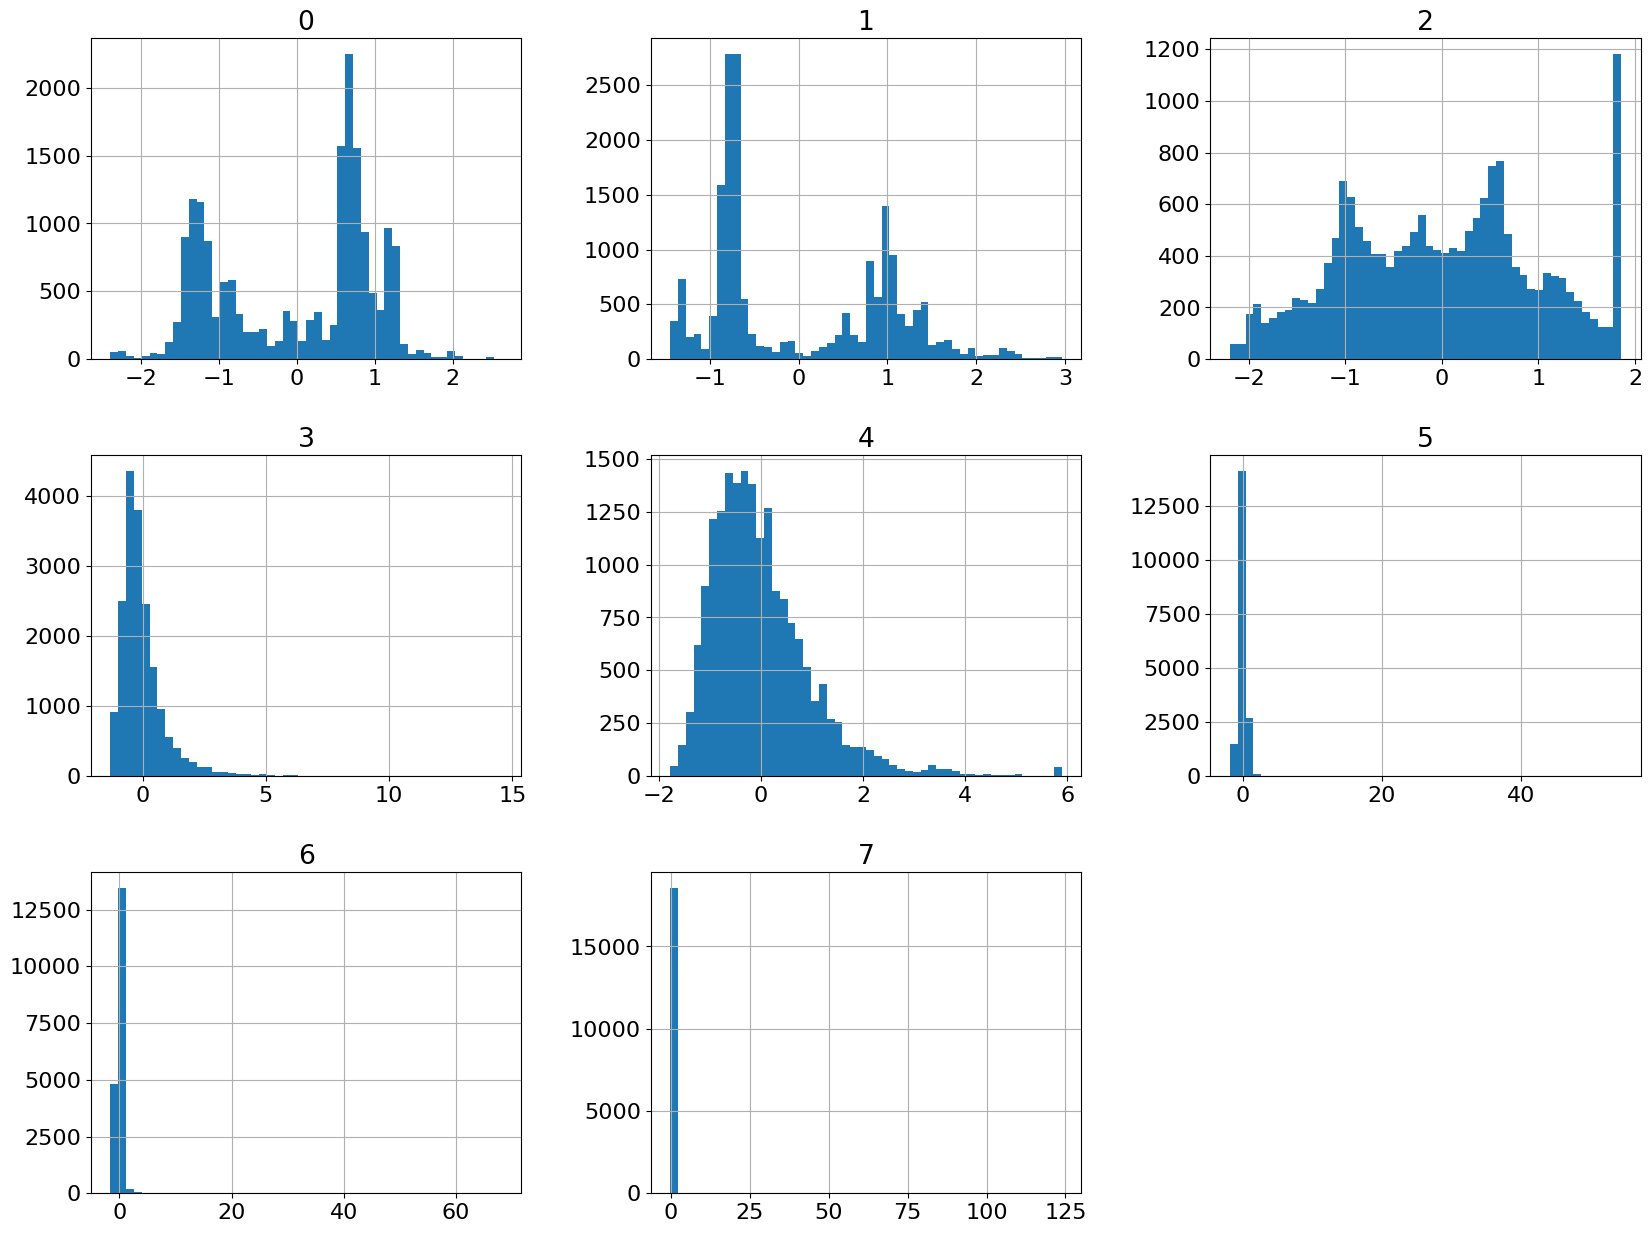

In [79]:
X_train_scaled_df=pd.DataFrame(X_train_scaled)
X_train_scaled_df.hist(bins=50, figsize=(20, 15));


In [80]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
knn.score(X_train_scaled, y_train)

0.7978563117812038

In [81]:
knn.score(X_test_scaled, y_test)

0.7124757464872105

- Big difference in the KNN training performance after scaling the data. 
- But we saw last week that training score doesn't tell us much. We should look at the cross-validation score. (Let's wait fpr thois a little bit more)

**Select all of the following statements which are TRUE.**

1. `StandardScaler` ensures a fixed range (i.e., minimum and maximum values) for the features. 
2. `StandardScaler` calculates mean and standard deviation for each feature separately. 
3. In general, it's a good idea to apply scaling on numeric features before training $k$-NN or SVM RBF models. 
4. The transformed feature values might be hard to interpret for humans.
5. After applying `SimpleImputer` The transformed data has a different shape than the original data.  

## Categorical features

- Recall that we had dropped the categorical feature `ocean_proximity` feature from the dataframe. But it could potentially be a useful feature in this task. 

- Let's create our `X_train` and and `X_test` again by keeping the feature in the data.

In [34]:
X_train

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,602.0,3.1250,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,20.0,3.4861,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,708.0,2.6604,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,285.0,5.2139,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,1458.0,1.8580,3.817558,1.004801,4.323045
...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,130.0,3.6389,5.584615,NaN,3.769231
15377,-117.24,33.37,14.0,779.0,4.5391,6.016688,1.017972,3.127086
17730,-121.76,37.33,5.0,697.0,5.6306,5.958393,1.031564,3.493544
15725,-122.44,37.78,44.0,326.0,3.8750,4.739264,1.024540,1.720859


In [22]:
X_train = train_df.drop(columns=["median_house_value"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value"])
y_test = test_df["median_house_value"]

In [23]:
X_train

,longitude,latitude,housing_median_age,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,602.0,3.1250,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,20.0,3.4861,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,708.0,2.6604,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,285.0,5.2139,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,1458.0,1.8580,NEAR OCEAN,3.817558,1.004801,4.323045
...,...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,130.0,3.6389,<1H OCEAN,5.584615,NaN,3.769231
15377,-117.24,33.37,14.0,779.0,4.5391,<1H OCEAN,6.016688,1.017972,3.127086
17730,-121.76,37.33,5.0,697.0,5.6306,<1H OCEAN,5.958393,1.031564,3.493544
15725,-122.44,37.78,44.0,326.0,3.8750,NEAR BAY,4.739264,1.024540,1.720859


- Let's try to build a `KNeighborRegressor`

In [24]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

ValueError: could not convert string to float: 'INLAND'

This failed because we have non-numeric data. 
- Imagine how $k$-NN would calculate distances when you have non-numeric features.

### Can we use this feature in the model? 
- In `scikit-learn`, most algorithms require numeric inputs.
- Decision trees could theoretically work with categorical features.  
    - However, the sklearn implementation does not support this. 

### What are the options? 

- Drop the column (not recommended)
    - If you know that the column is not relevant to the target in any way you may drop it. 
- We can transform categorical features to numeric ones so that we can use them in the model.     
    - [Ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (occasionally recommended)
    - One-hot encoding (recommended in most cases) (this lecture)

In [25]:
X_toy = pd.DataFrame(
    {
        "language": [
            "English",
            "Vietnamese",
            "English",
            "Mandarin",
            "English",
            "English",
            "Mandarin",
            "English",
            "Vietnamese",
            "Mandarin",
            "French",
            "Spanish",
            "Mandarin",
            "Hindi",
        ]
    }
)
X_toy

,language
0,English
1,Vietnamese
2,English
3,Mandarin
4,English
5,English
6,Mandarin
7,English
8,Vietnamese
9,Mandarin


### Ordinal encoding (occasionally recommended)

- Here we simply assign an integer to each of our unique categorical labels. 
- We can use sklearn's [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [26]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc.fit(X_toy)
X_toy_ord = enc.transform(X_toy)
df = pd.DataFrame(
    data=X_toy_ord,
    columns=["language_enc"],
    index=X_toy.index,
)
pd.concat([X_toy, df], axis=1)

,language,language_enc
0,English,0.0
1,Vietnamese,5.0
2,English,0.0
3,Mandarin,3.0
4,English,0.0
5,English,0.0
6,Mandarin,3.0
7,English,0.0
8,Vietnamese,5.0
9,Mandarin,3.0


What's the problem with this approach? 
- We have imposed ordinality on the categorical data.
- For example, imagine when you are calculating distances. Is it fair to say that French and Hindi are closer than French and Spanish? 
- In general, label encoding is useful if there is ordinality in your data and capturing it is important for your problem, e.g., `[cold, warm, hot]`. 

#### One-hot encoding (OHE)
- Create new binary columns to represent our categories.
- If we have $c$ categories in our column.
    - We create $c$ new binary columns to represent those categories.
- Example: Imagine a language column which has the information on whether you 

- We can use sklearn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to do so.

One-hot encoding is called one-hot because only one of the newly created features is 1 for each data point. 


In [28]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
enc.fit(X_toy)
X_toy_ohe = enc.transform(X_toy)
pd.DataFrame(
    data=X_toy_ohe,
    columns=enc.get_feature_names_out(["language"]),
    index=X_toy.index,
)

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,language_English,language_French,language_Hindi,language_Mandarin,language_Spanish,language_Vietnamese
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,1.0,0.0,0.0


### Let's do it on our housing data

In [29]:
ohe = OneHotEncoder(sparse=False, dtype="int")
ohe.fit(X_train[["ocean_proximity"]])
X_imp_ohe_train = ohe.transform(X_train[["ocean_proximity"]])

C:\Users\sanjay\anaconda3\envs\pytorch_cuda\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


- We can look at the new features created using `categories_` attribute

In [30]:
ohe.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [31]:
X_imp_ohe_train

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0]])

In [33]:
transformed_ohe = pd.DataFrame(
    data=X_imp_ohe_train,
    columns=ohe.get_feature_names_out(["ocean_proximity"]),
    index=X_train.index,
)
transformed_ohe

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
6051,0,1,0,0,0
20113,0,1,0,0,0
14289,0,0,0,0,1
13665,0,1,0,0,0
14471,0,0,0,0,1
...,...,...,...,...,...
7763,1,0,0,0,0
15377,1,0,0,0,0
17730,1,0,0,0,0
15725,0,0,0,1,0


## Pipeline and Column Transformer in `sklearn`

In [84]:
### Simple example of a pipeline
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("regressor", KNeighborsRegressor()),
    ]
)

## Alternative and more compact syntax: `make_pipeline`


In [86]:
from sklearn.pipeline import make_pipeline


In [87]:
pipe = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), KNeighborsRegressor()
)

In [88]:
X_train

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,602.0,3.1250,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,20.0,3.4861,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,708.0,2.6604,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,285.0,5.2139,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,1458.0,1.8580,3.817558,1.004801,4.323045
...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,130.0,3.6389,5.584615,NaN,3.769231
15377,-117.24,33.37,14.0,779.0,4.5391,6.016688,1.017972,3.127086
17730,-121.76,37.33,5.0,697.0,5.6306,5.958393,1.031564,3.493544
15725,-122.44,37.78,44.0,326.0,3.8750,4.739264,1.024540,1.720859


In [89]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

In [90]:
pipe.score(X_train, y_train)

0.7978563117812038

In [91]:
pipe.score(X_test, y_test)

0.7124757464872105

## `ColumnTransformer` on the California housing dataset


In [92]:
housing_df = pd.read_csv("data/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN


In [93]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

train_df = train_df.assign(
    bedrooms_per_household=train_df["total_bedrooms"] / train_df["households"]
)
test_df = test_df.assign(
    bedrooms_per_household=test_df["total_bedrooms"] / test_df["households"]
)

train_df = train_df.assign(
    population_per_household=train_df["population"] / train_df["households"]
)
test_df = test_df.assign(
    population_per_household=test_df["population"] / test_df["households"]
)

In [94]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN,3.817558,1.004801,4.323045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,726.0,NaN,490.0,130.0,3.6389,167600.0,<1H OCEAN,5.584615,NaN,3.769231
15377,-117.24,33.37,14.0,4687.0,793.0,2436.0,779.0,4.5391,180900.0,<1H OCEAN,6.016688,1.017972,3.127086
17730,-121.76,37.33,5.0,4153.0,719.0,2435.0,697.0,5.6306,286200.0,<1H OCEAN,5.958393,1.031564,3.493544
15725,-122.44,37.78,44.0,1545.0,334.0,561.0,326.0,3.8750,412500.0,NEAR BAY,4.739264,1.024540,1.720859


In [95]:
# Let's keep both numeric and categorical columns in the data.
X_train = train_df.drop(columns=["median_house_value", "total_rooms", "total_bedrooms", "population"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value", "total_rooms", "total_bedrooms", "population"])
y_test = test_df["median_house_value"]

In [96]:
from sklearn.compose import ColumnTransformer, make_column_transformer


In [97]:
X_train.head(10)


,longitude,latitude,housing_median_age,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,602.0,3.1250,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,20.0,3.4861,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,708.0,2.6604,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,285.0,5.2139,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,1458.0,1.8580,NEAR OCEAN,3.817558,1.004801,4.323045
9730,-121.74,36.79,16.0,611.0,4.3814,<1H OCEAN,6.286416,1.014730,2.944354
14690,-117.09,32.80,36.0,360.0,4.7188,NEAR OCEAN,6.008333,1.019444,2.541667
7938,-118.11,33.86,33.0,393.0,5.3889,<1H OCEAN,6.078880,1.043257,3.127226
18365,-122.12,37.28,21.0,56.0,5.8691,<1H OCEAN,6.232143,1.142857,2.660714
10931,-117.91,33.74,25.0,922.0,2.9926,<1H OCEAN,4.634490,1.046638,3.195228


In [98]:
X_train.columns


Index(['longitude', 'latitude', 'housing_median_age', 'households',
       'median_income', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_household', 'population_per_household'],
      dtype='object')

In [104]:
# Identify the categorical and numeric columns
numeric_features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "households",
    "median_income",
    "rooms_per_household",
    "bedrooms_per_household",
    "population_per_household",
]

categorical_features = ["ocean_proximity"]
target = "median_income"

- Let's create a ColumnTransformer for our dataset.


In [99]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18576 entries, 6051 to 19966
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 18576 non-null  float64
 1   latitude                  18576 non-null  float64
 2   housing_median_age        18576 non-null  float64
 3   households                18576 non-null  float64
 4   median_income             18576 non-null  float64
 5   ocean_proximity           18576 non-null  object 
 6   rooms_per_household       18576 non-null  float64
 7   bedrooms_per_household    18391 non-null  float64
 8   population_per_household  18576 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.4+ MB


In [100]:
X_train["ocean_proximity"].value_counts()


<1H OCEAN     8221
INLAND        5915
NEAR OCEAN    2389
NEAR BAY      2046
ISLAND           5
Name: ocean_proximity, dtype: int64

In [101]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [102]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [105]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
)

In [106]:
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'households', 'median_income',
                                  'rooms_per_household',
                                  'bedrooms_per_household',
                                  'population_per_household']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['ocean_proximity'])])

In [107]:
X_train_pp = preprocessor.fit_transform(X_train)


In [108]:
preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
    categorical_features
)

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [109]:
column_names = numeric_features + list(
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_features
    )
)
column_names

['longitude',
 'latitude',
 'housing_median_age',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_household',
 'population_per_household',
 'ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [110]:
pd.DataFrame(X_train_pp, columns=column_names)


,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.908140,-0.743917,-0.526078,0.266135,-0.389736,-0.210591,-0.083813,0.126398,0.0,1.0,0.0,0.0,0.0
1,-0.002057,1.083123,-0.923283,-1.253312,-0.198924,4.726412,11.166631,-0.050132,0.0,1.0,0.0,0.0,0.0
2,1.218207,-1.352930,1.380504,0.542873,-0.635239,-0.273606,-0.025391,-0.099240,0.0,0.0,0.0,0.0,1.0
3,1.128188,-0.753286,-0.843842,-0.561467,0.714077,0.122307,-0.280310,0.010183,0.0,1.0,0.0,0.0,0.0
4,1.168196,-1.287344,-0.843842,2.500924,-1.059242,-0.640266,-0.190617,0.126808,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18571,0.733102,-0.804818,0.586095,-0.966131,-0.118182,0.063110,-0.099558,0.071541,1.0,0.0,0.0,0.0,0.0
18572,1.163195,-1.057793,-1.161606,0.728235,0.357500,0.235096,-0.163397,0.007458,1.0,0.0,0.0,0.0,0.0
18573,-1.097293,0.797355,-1.876574,0.514155,0.934269,0.211892,-0.135305,0.044029,1.0,0.0,0.0,0.0,0.0
18574,-1.437367,1.008167,1.221622,-0.454427,0.006578,-0.273382,-0.149822,-0.132875,0.0,0.0,0.0,1.0,0.0


In [111]:
knn_pipe = make_pipeline(preprocessor, KNeighborsRegressor())


In [112]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'households',
                                                   'median_income',
                                                   'rooms_per_household',
                                                   'bedrooms_per_household',
                                                   'population_per_household']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [113]:
knn_pipe.score(X_train, y_train)

0.8059396097446094

In [114]:
knn_pipe.score(X_test, y_test)

0.7264637019551918